## Linear Regression Models for Asset Pricing

### CAPM Theory

Sharpe (1964) and Lintner (1965) developed the Capital Asset Pricing Model for a market in which investors have the same expectations, hold portfolios of risky assets that are mean-variance efficient, and can borrow and lend money freely at the same risk-free rate. In such a market, the expected return of asset j is
$$
E[R_j] = R_f + \beta_j(E[R_m]-R_f),
$$

$$
\beta_j = \frac{cov(R_j,R_m)}{Var[R_m]}
$$

where $R_m$ is the return on the market portfolio and $R_f$ is the return on the risk-free asset.
Consider fitting the simple linear regression model of a stock’s daily excess return on the market-portfolio daily excess return, using the S&P 500 Index as the proxy for the market return and the 3-month Treasury constant maturity rate as the risk-free rate. The linear model is given by:

$$
R_{j,t}^{*}=\alpha_j+\beta_j R^*_{m,t}+\epsilon_{j,t}, \ \ t=1,2
$$

where $\epsilon_{j,t}$ are white noise: $WN(0,\sigma^2)$.

Under the assumptions of the CAPM, the regression parameters $(\alpha_j , \beta_j)$ are such that $\beta_j$ is the same as in the CAPM model, and $\alpha_j$ is zero.

### Historical financial data

In [1]:
import pandas as pd
#import pandas_datareader.data as web
import datetime
import numpy as np
import seaborn as sns
from pylab import mpl, plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

In [2]:
data = pd.read_csv('data.csv', index_col=0)

In [3]:
data.tail()

,SP500,GE,BAC,XOM,DGS3MO,DGS1,DGS5,DGS10,DAAA,DBAA,DCOILWTICO
2021-10-11,4361.189941,104.080002,43.779999,61.560001,0.05,0.09,1.05,1.61,2.77,3.45,79.55
2021-10-12,4350.649902,102.720001,43.540001,61.240002,0.06,0.10,1.08,1.59,2.75,3.41,80.75
2021-10-13,4363.799805,102.360001,43.139999,61.070000,0.05,0.11,1.09,1.56,2.66,3.35,80.75
2021-10-14,4438.259766,102.739998,45.070000,62.000000,0.05,0.10,1.05,1.52,2.62,3.33,80.75
2021-10-15,4471.370117,104.410004,46.369999,62.590000,0.05,0.10,1.05,1.52,2.62,3.33,80.75


In [4]:
data['Date'] = pd.to_datetime(data.index, format='%Y/%m/%d')
data = data.set_index(['Date'])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2011-10-17 to 2021-10-15
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SP500       2517 non-null   float64
 1   GE          2517 non-null   float64
 2   BAC         2517 non-null   float64
 3   XOM         2517 non-null   float64
 4   DGS3MO      2517 non-null   float64
 5   DGS1        2517 non-null   float64
 6   DGS5        2517 non-null   float64
 7   DGS10       2517 non-null   float64
 8   DAAA        2517 non-null   float64
 9   DBAA        2517 non-null   float64
 10  DCOILWTICO  2517 non-null   float64
dtypes: float64(11)
memory usage: 236.0 KB


We first plot the raw data for the stock GE, the market-portfolio index SP 500, and the risk-free interest rate.

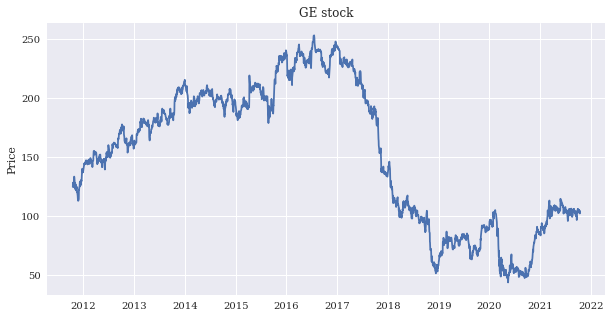

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(data["GE"])
plt.ylabel("Price")
plt.title("GE stock");

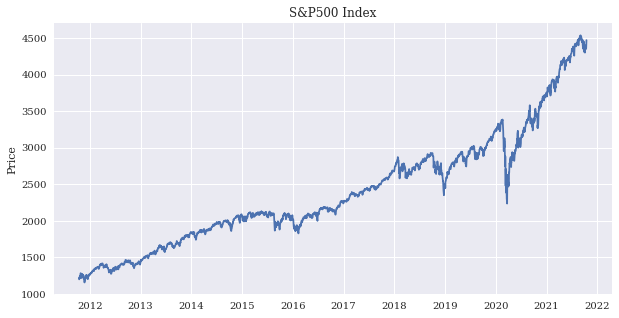

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(data["SP500"])
plt.ylabel("Price")
plt.title("S&P500 Index");

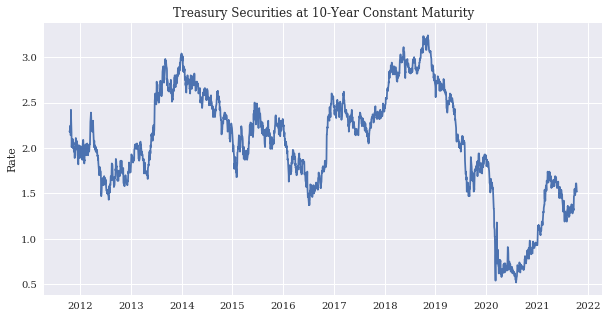

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(data["DGS10"])
plt.ylabel("Rate")
plt.title("Treasury Securities at 10-Year Constant Maturity");

Now we construct the variables with the log daily returns of GE and the SP500 index as well as the risk-free asset returns.

In [9]:
# Compute daily log returns of GE stock
r_daily_GE = np.log(data['GE'] / data['GE'].shift(1))
r_daily_GE = pd.DataFrame(r_daily_GE)
r_daily_GE.columns = ['r_daily_GE']

In [10]:
r_daily_GE.head()

,r_daily_GE
Date,
2011-10-17,NaN
2011-10-18,0.029146
2011-10-19,-0.011436
2011-10-20,0.006637
2011-10-21,-0.019430


In [11]:
# Compute daily log returns of the SP500 index
r_daily_SP500 = np.log(data['SP500'] / data['SP500'].shift(1))
r_daily_SP500 = pd.DataFrame(r_daily_SP500)
r_daily_SP500.columns = ['r_daily_SP500']

In [12]:
# Compute the return of risk-free rate

r_f = .01*data['DGS10']

In [13]:
# Compute excess returns (over riskfree rate)

r_daily_GE_0 = r_daily_GE - r_f.values.reshape(-1,1)
r_daily_GE_0.columns = ['r_daily_GE_0']
r_daily_SP500_0 = r_daily_SP500 - r_f.values.reshape(-1,1)
r_daily_SP500_0.columns = ['r_daily_SP500_0']

In [14]:
# Merge all the time series together,
# and display first and last sets of rows

r_daily_data0 = pd.concat([r_daily_GE, r_daily_SP500,
                     r_daily_GE_0, r_daily_SP500_0], axis=1).dropna()

In [15]:
r_daily_data0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2011-10-18 to 2021-10-15
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   r_daily_GE       2516 non-null   float64
 1   r_daily_SP500    2516 non-null   float64
 2   r_daily_GE_0     2516 non-null   float64
 3   r_daily_SP500_0  2516 non-null   float64
dtypes: float64(4)
memory usage: 98.3 KB


Now we plot the excess returns of GE vs those of the SP500:

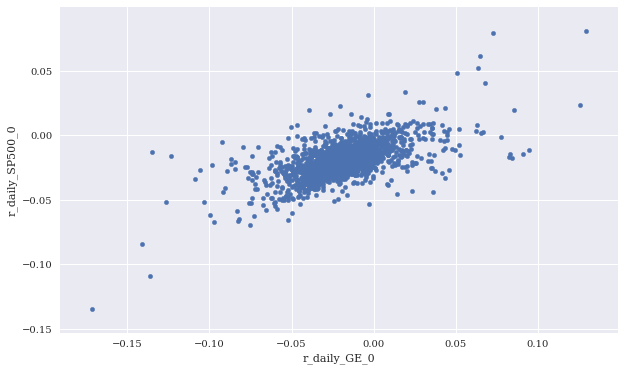

In [16]:
r_daily_data0.plot(kind='scatter', x='r_daily_GE_0', 
                   y='r_daily_SP500_0', figsize=(10, 6));

### Fitting the Linear Regression for CAPM

In [17]:
model = ols('r_daily_GE_0 ~ r_daily_SP500_0', data=r_daily_data0).fit()

In [18]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           r_daily_GE_0   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     1649.
Date:                Wed, 20 Oct 2021   Prob (F-statistic):          1.08e-277
Time:                        18:34:17   Log-Likelihood:                 6745.9
No. Observations:                2516   AIC:                        -1.349e+04
Df Residuals:                    2514   BIC:                        -1.348e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0015      0.001     

### Regression Diagnostics

get_influence() computes regression diagnostics evaluating case influence for the linear regression model; includes ‘hat’ matirx, case-deletion statistics for the regression coefficients and for the residual standard deviation.

In [19]:
# Compute influence measures (case-deletion statistics)

infl = model.get_influence()

In [20]:
infl.summary_frame().head()

,dfb_Intercept,dfb_r_daily_SP500_0,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
Date,,,,,,,,
2011-10-18,0.016607,0.013834,0.000138,0.461840,0.001294,0.016623,0.461768,0.016620
2011-10-19,-0.002039,-0.004869,0.000020,0.204101,0.000966,0.006348,0.204062,0.006346
2011-10-20,0.002035,0.000603,0.000004,0.146538,0.000414,0.002984,0.146510,0.002983
2011-10-21,-0.078489,-0.063169,0.003102,-2.362556,0.001110,-0.078765,-2.364712,-0.078837
2011-10-24,-0.007017,-0.004768,0.000027,-0.283777,0.000680,-0.007401,-0.283725,-0.007400


This generates a useful 2x2 display of plots for various regression diagnostic statistics:

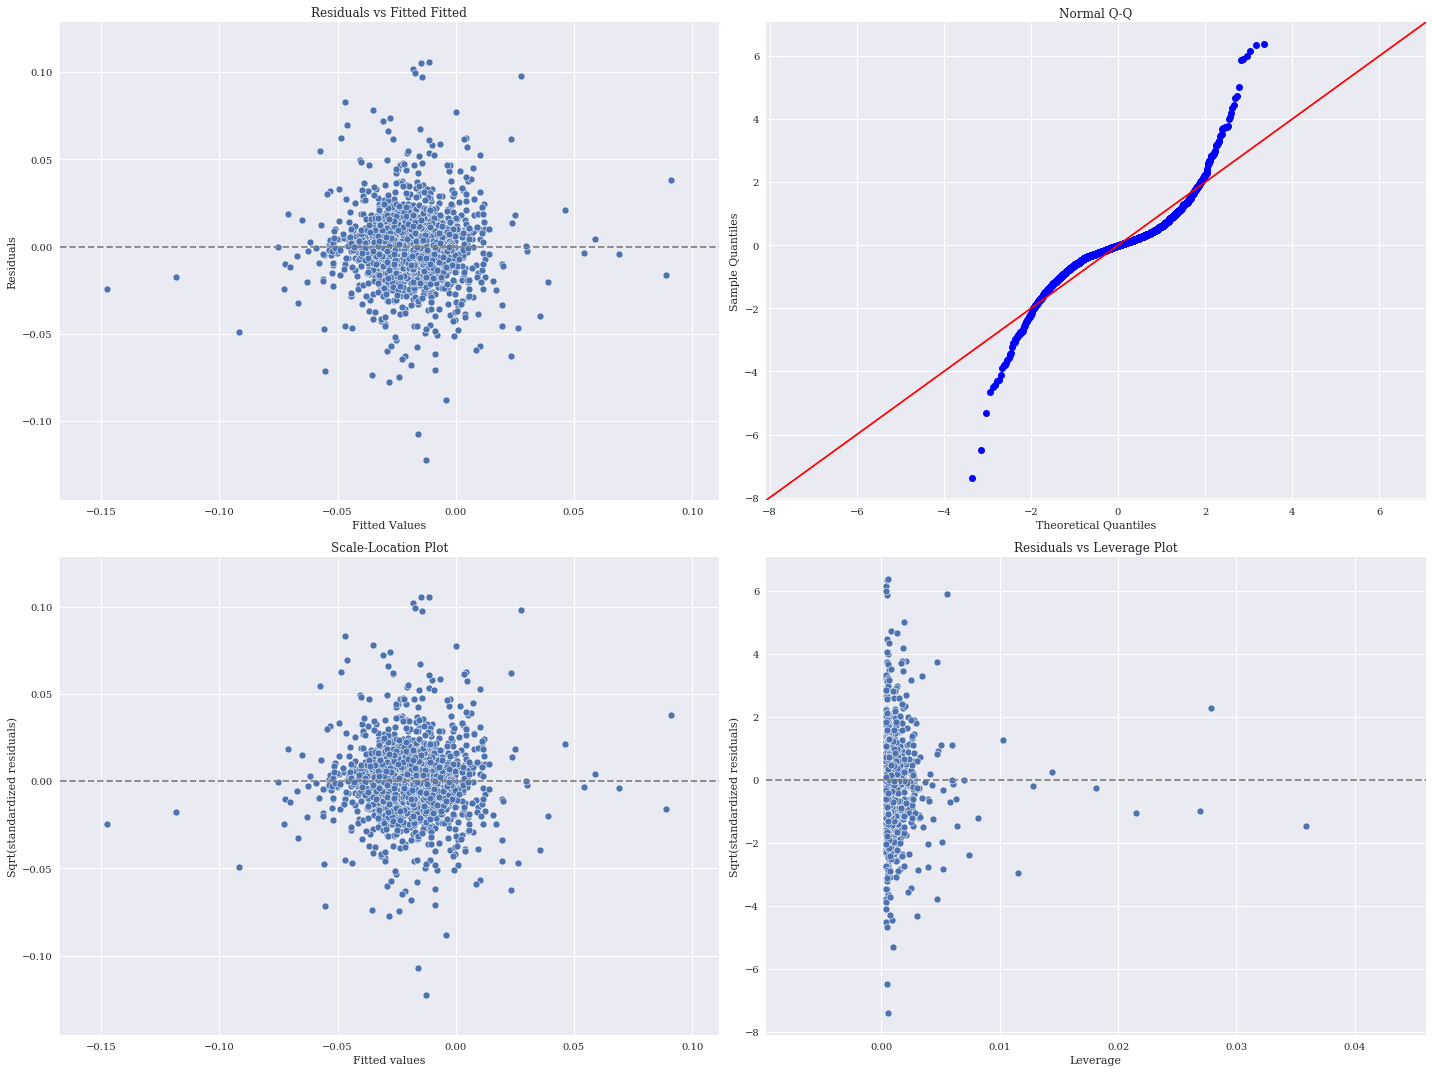

In [21]:
# Get different Variables for diagnostic
residuals = model.resid
fitted_value = model.fittedvalues
stand_resids = model.resid_pearson
influence = model.get_influence()
leverage = influence.hat_matrix_diag
  
# PLot different diagnostic plots
plt.rcParams["figure.figsize"] = (20,15)
fig, ax = plt.subplots(nrows=2, ncols=2)
  
plt.style.use('seaborn')
  
# Residual vs Fitted Plot
sns.scatterplot(x=fitted_value, y=residuals, ax=ax[0, 0])
ax[0, 0].axhline(y=0, color='grey', linestyle='dashed')
ax[0, 0].set_xlabel('Fitted Values')
ax[0, 0].set_ylabel('Residuals')
ax[0, 0].set_title('Residuals vs Fitted Fitted')
  
# Normal Q-Q plot
sm.qqplot(residuals, fit=True, line='45',ax=ax[0, 1], c='#4C72B0')
ax[0, 1].set_title('Normal Q-Q')
  
# Scale-Location Plot
sns.scatterplot(x=fitted_value, y=residuals, ax=ax[1, 0])
ax[1, 0].axhline(y=0, color='grey', linestyle='dashed')
ax[1, 0].set_xlabel('Fitted values')
ax[1, 0].set_ylabel('Sqrt(standardized residuals)')
ax[1, 0].set_title('Scale-Location Plot')
  
# Residual vs Leverage Plot
sns.scatterplot(x=leverage, y=stand_resids, ax=ax[1, 1])
ax[1, 1].axhline(y=0, color='grey', linestyle='dashed')
ax[1, 1].set_xlabel('Leverage')
ax[1, 1].set_ylabel('Sqrt(standardized residuals)')
ax[1, 1].set_title('Residuals vs Leverage Plot')
  
plt.tight_layout()
plt.show()

In [22]:
#fig = sm.graphics.influence_plot(model, criterion="cooks")
#fig.tight_layout(pad=1.0)

Visually inspecting the data is a good thing. But being able to detect outliers and/or influential points automatically is preferable, especially when the number of observations is high. To do this, we need to define threshold values from which a point becomes suspect.

- For the leverage, the threshold value may be:
$$s_h = 2\times\frac{p+1}{n}$$

An observation is suspicious if $h_i>s_h$.

In [23]:
# Threshold leverage
leviers = infl.hat_matrix_diag
seuil_levier = 2*(1+1)/len(r_daily_data0)
print(seuil_levier)
# Identification
atyp_levier = leviers > seuil_levier
print(atyp_levier)

0.001589825119236884
[False False False ... False  True False]


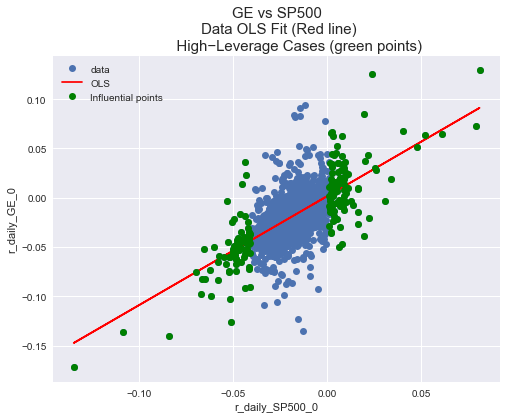

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

x = r_daily_data0.iloc[:,3].values.reshape(-1, 1)
y = r_daily_data0.iloc[:,2].values.reshape(-1, 1)
ax.plot(x, y, 'o', label="data") # Plot GE vs SP500
ax.plot(x, model.fittedvalues, "r", label="OLS") # Plot fitted regression line
ax.plot(r_daily_data0.iloc[atyp_levier>0,3], r_daily_data0.iloc[atyp_levier>0,2], 
       'go', label = 'Influential points') # Plot cases with high leverage
plt.xlabel('r_daily_SP500_0')
plt.ylabel('r_daily_GE_0')
plt.title('GE vs SP500\n Data OLS Fit (Red line)\n \
          High−Leverage Cases (green points)', size=15)
ax.legend(loc="best");

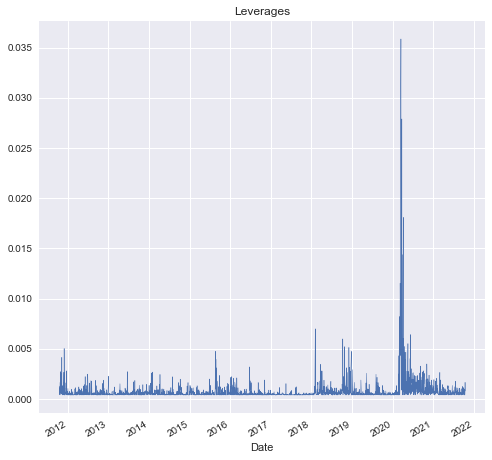

In [25]:
plt.figure(figsize=(8, 8))
infl.summary_frame()['hat_diag'].plot(linewidth=0.5,)
plt.title('Leverages');

### Adding Macro-economic Factors to CAPM

The CAPM relates a stock’s return to that of the diversified market portfolio, proxied here by the S&P 500 Index. A stock’s return can depend on macro-economic factors, such commodity prices, interest rates, economic growth (GDP).

In [26]:
# Compute daily log returns of DCOILWTICO stock
r_daily_DCOILWTICO = np.log(data['DCOILWTICO'] / data['DCOILWTICO'].shift(1))
r_daily_DCOILWTICO = pd.DataFrame(r_daily_DCOILWTICO)
r_daily_DCOILWTICO.columns = ['r_daily_DCOILWTICO']
# Compute daily log returns of Exxon-Mobil stock, XOM
r_daily_XOM = np.log(data['XOM'] / data['XOM'].shift(1))
r_daily_XOM = pd.DataFrame(r_daily_XOM)
r_daily_XOM.columns = ['r_daily_XOM']

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
# Compute excess returns (over riskfree rate)

r_daily_DCOILWTICO_0 = r_daily_DCOILWTICO - r_f.values.reshape(-1,1)
r_daily_DCOILWTICO_0.columns = ['r_daily_DCOILWTICO_0']
r_daily_XOM_0 = r_daily_XOM - r_f.values.reshape(-1,1)
r_daily_XOM_0.columns = ['r_daily_XOM_0']

In [28]:
# Merge the returns of DCOILWTICO to the stocks
r_daily_data1 = pd.concat([r_daily_data0, r_daily_DCOILWTICO_0, 
                          r_daily_XOM_0], axis=1).dropna()

In [29]:
model1 = ols('r_daily_GE_0 ~ r_daily_SP500_0 + r_daily_DCOILWTICO_0', 
                 data=r_daily_data1).fit()

In [30]:
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:           r_daily_GE_0   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     828.7
Date:                Wed, 20 Oct 2021   Prob (F-statistic):          4.26e-277
Time:                        18:34:20   Log-Likelihood:                 6744.0
No. Observations:                2514   AIC:                        -1.348e+04
Df Residuals:                    2511   BIC:                        -1.346e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0016 

The regression coefficient for the oil factor (r_daily_DCOILWTICO) is statistically insignificant (p>0.05). Over the analysis period, price changes in GE stock are not related to the price changes in oil.

Consider the corresponding models for Exxon-Mobil stock, XOM

In [31]:
model2 = ols('r_daily_XOM_0 ~ r_daily_SP500_0 + r_daily_DCOILWTICO_0', 
                 data=r_daily_data1).fit()

In [32]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:          r_daily_XOM_0   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     1638.
Date:                Wed, 20 Oct 2021   Prob (F-statistic):               0.00
Time:                        18:34:20   Log-Likelihood:                 7756.9
No. Observations:                2514   AIC:                        -1.551e+04
Df Residuals:                    2511   BIC:                        -1.549e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0002 

The regression coefficient for the oil factor (r_daily_DCOILWTICO) is statistically significant. Over the analysis period, price changes in XOM stock are positively related to the price changes in oil.

## References

- https://ocw.mit.edu/courses/mathematics/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/video-lectures/lecture-6-regression-analysis/

- https://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/en_Tanagra_Python_StatsModels.pdf